<a href="https://colab.research.google.com/github/basvoju/basvoju/blob/main/deep_learning_live_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jovian --upgrade -q
import jovian
jovian.set_project('deep-learning-live-project')
jovian.set_colab_id('1ARhtyV-B4h_mjk0sNqaHQwDLsdS_1fXv')

     |████████████████████████████████| 68 kB 5.3 MB/s 


# deep-learning-live-project

Use the "Run" button to execute the code.

# New Section

### Identifying Flower Species using Deep Learning and Pytorch

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [84]:
# Execute this to save new versions of the notebook
jovian.commit(project="deep-learning-live-project")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/basvojusandeepa2-hwa/deep-learning-live-project


'https://jovian.ai/basvojusandeepa2-hwa/deep-learning-live-project'

In [5]:
!pip install opendatasets --upgrade --quiet

In [6]:
import opendatasets as od

In [7]:
dataset_url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'

In [8]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nagasandeepabasvoju
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:00<00:00, 271MB/s]


Import the dataset into Pytorch

1.   Use the "Image Folder" class from Torchvision.



In [9]:
data_dir = './flowers-recognition/flowers'

In [10]:
import os

In [11]:
os.listdir(data_dir)

['sunflower', 'rose', 'dandelion', 'daisy', 'tulip']

In [12]:
 from torchvision.datasets import ImageFolder

In [13]:
dataset = ImageFolder(data_dir)

In [14]:
len(dataset)

4317

In [15]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F84D1F4EB90>, 0)

In [16]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

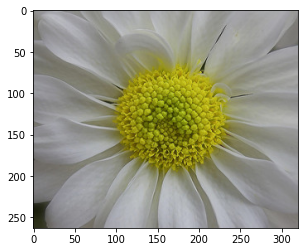

In [18]:
img, label = dataset[0]
plt.imshow(img)

In [19]:
import torchvision.transforms as tt
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),tt.RandomCrop(64), 
                                             tt.ToTensor()]))

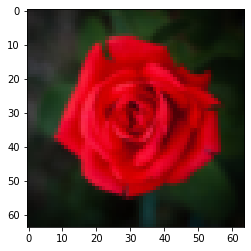

In [20]:
img, label = dataset[2522]
plt.imshow(img.permute(1,2,0))

In [21]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset)-val_size

In [22]:
train_size, val_size

(3886, 431)

In [23]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds),len(val_ds)

(3886, 431)

In [24]:
from torch.utils.data import DataLoader
batch_size = 128 

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size, num_workers = 2, pin_memory = True)

In [25]:
from torchvision.utils import make_grid
    
def show_batch(dl):
    for images, labels in dl:
      fig, ax = plt.subplots(figsize=(12, 6))
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
      break 

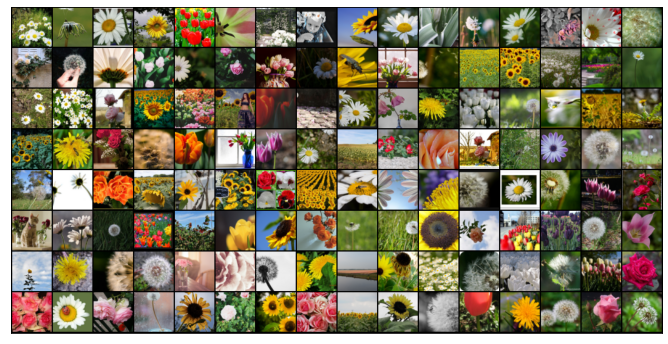

In [26]:
show_batch(train_dl)

In [27]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

sunflower : 733
rose : 784
dandelion : 1052
daisy : 764
tulip : 984


### GPU Utilities

In [28]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [29]:
torch.cuda.is_available()

True

In [30]:
device = get_default_device()

In [31]:
device

device(type='cuda')

In [32]:
img, label = dataset[0] 

In [33]:
img.shape

torch.Size([3, 64, 64])

In [34]:
 img.device

device(type='cpu')

In [35]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [36]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

Model & Training Utilities

In [37]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Model

In [39]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [40]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [41]:
model.conv1[0].weight

Parameter containing:
tensor([[[[ 0.1785,  0.0711,  0.0938],
          [ 0.1299,  0.1922,  0.0825],
          [ 0.0649,  0.0847, -0.0993]],

         [[ 0.1716,  0.0235,  0.0807],
          [-0.0261,  0.0978,  0.1179],
          [-0.0969, -0.0999,  0.1799]],

         [[ 0.0987,  0.0135,  0.0420],
          [ 0.0111,  0.0453,  0.0587],
          [-0.1365, -0.1083,  0.1902]]],


        [[[-0.0801, -0.0738, -0.1291],
          [-0.0708,  0.0770, -0.1526],
          [-0.0648, -0.1491, -0.1260]],

         [[-0.0820, -0.1244, -0.0142],
          [-0.1244, -0.0492, -0.1773],
          [-0.0670, -0.0480, -0.0372]],

         [[ 0.0930, -0.0229,  0.0322],
          [ 0.0902,  0.0926, -0.0554],
          [-0.1258, -0.0191, -0.1014]]],


        [[[-0.0424, -0.1119,  0.1410],
          [ 0.0574, -0.0832, -0.0489],
          [ 0.0501,  0.0784,  0.1357]],

         [[ 0.0978,  0.0999, -0.1507],
          [ 0.0746,  0.1537, -0.0885],
          [-0.1394, -0.1916, -0.1177]],

         [[-0.1419, -0

In [42]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Passing one batch of input tensor through the model

In [43]:
for batch in train_dl:
  images, labels = batch
  print('', images.shape)
  print(images.device)
  preds= model(images)
  print('preds.shape',preds.shape)
  break

 torch.Size([128, 3, 64, 64])
cuda:0
preds.shape torch.Size([128, 5])


Training

In [44]:
history = [evaluate(model,val_dl)]
history

[{'val_acc': 0.17677858471870422, 'val_loss': 1.6083046197891235}]

In [45]:
history+= fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.4783, val_loss: 1.3411, val_acc: 0.4127
Epoch [1], train_loss: 1.0056, val_loss: 0.8569, val_acc: 0.6660
Epoch [2], train_loss: 0.9200, val_loss: 0.9888, val_acc: 0.6417
Epoch [3], train_loss: 0.8404, val_loss: 0.7625, val_acc: 0.6903
Epoch [4], train_loss: 0.7588, val_loss: 0.6981, val_acc: 0.7453


In [46]:
history+= fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8607, val_loss: 0.6743, val_acc: 0.7372
Epoch [1], train_loss: 0.7058, val_loss: 0.8433, val_acc: 0.6873
Epoch [2], train_loss: 0.6233, val_loss: 0.7879, val_acc: 0.7232
Epoch [3], train_loss: 0.5627, val_loss: 0.6956, val_acc: 0.7707
Epoch [4], train_loss: 0.5164, val_loss: 0.8399, val_acc: 0.7389


In [47]:
history+= fit(5, 0.0001, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3986, val_loss: 0.4771, val_acc: 0.8126
Epoch [1], train_loss: 0.3568, val_loss: 0.5647, val_acc: 0.8098
Epoch [2], train_loss: 0.3224, val_loss: 0.4797, val_acc: 0.8305
Epoch [3], train_loss: 0.3207, val_loss: 0.5111, val_acc: 0.8204
Epoch [4], train_loss: 0.3017, val_loss: 0.5202, val_acc: 0.8238


In [48]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

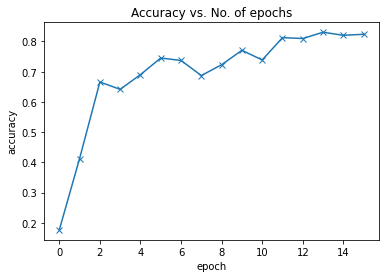

In [49]:
plot_accuracies(history)

In [50]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

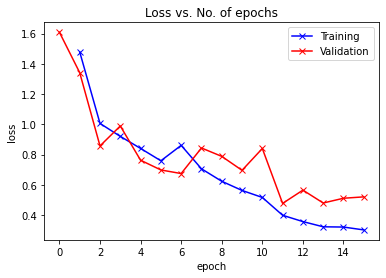

In [51]:
plot_losses(history)

In [52]:
history[-1]

{'train_loss': 0.3017405569553375,
 'val_acc': 0.8237616419792175,
 'val_loss': 0.5201641917228699}

In [53]:
jovian.reset()
jovian.log_dataset(image_size = 64)
jovian.log_hyperparams(batch_size=128, 
                       arch = 'ResNet9', 
                       epochs = [5,5,5,5],
                       lrs = [0.001, 0.0001],
                       opt ='Adam')
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_acc = history[-1]['val_acc'],
                   val_loss = history[-1]['val_loss'])


[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [54]:
jovian.commit(project="deep-learning-live-project")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/basvojusandeepa2-hwa/deep-learning-live-project


'https://jovian.ai/basvojusandeepa2-hwa/deep-learning-live-project'

In [63]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [74]:
def show_image_prediction(img, label):
  plt.imshow(img.permute((1,2,0)))
  pred=predict_image(img, model)
  print('Target:',dataset.classes[label])
  print('Prediction:',pred)

Target: daisy
Prediction: daisy


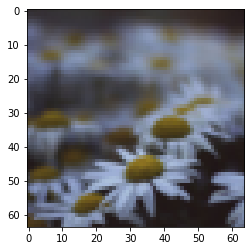

In [80]:
show_image_prediction(*val_ds[136]) 

In [81]:
torch.save(model.state_dict(),'flowers-resnet9.pth')

In [83]:
jovian.commit(project='deep-learning-project-live',
              outputs=['flowers-resnet9.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/basvojusandeepa2-hwa/deep-learning-project-live


'https://jovian.ai/basvojusandeepa2-hwa/deep-learning-project-live'